# **Librerias**

In [1]:
# Importamos 

import torch 
import warnings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam

# Verbose 

warnings.filterwarnings(action = 'ignore', category = UserWarning)

# Version 

print(f'Numpy Version: {np.__version__}')
print(f'Torch Version: {torch.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.0.2
Torch Version: 2.6.0+cpu
Matplotlib Version: 3.9.4


# **Funcion de Perdidas**

$$L(\theta) = (x^2 - 1)^2 + (y^2 - 1)^2 + 1.5 \cdot \sin({7 \cdot x}) \cdot \sin({5.5 \cdot y})$$

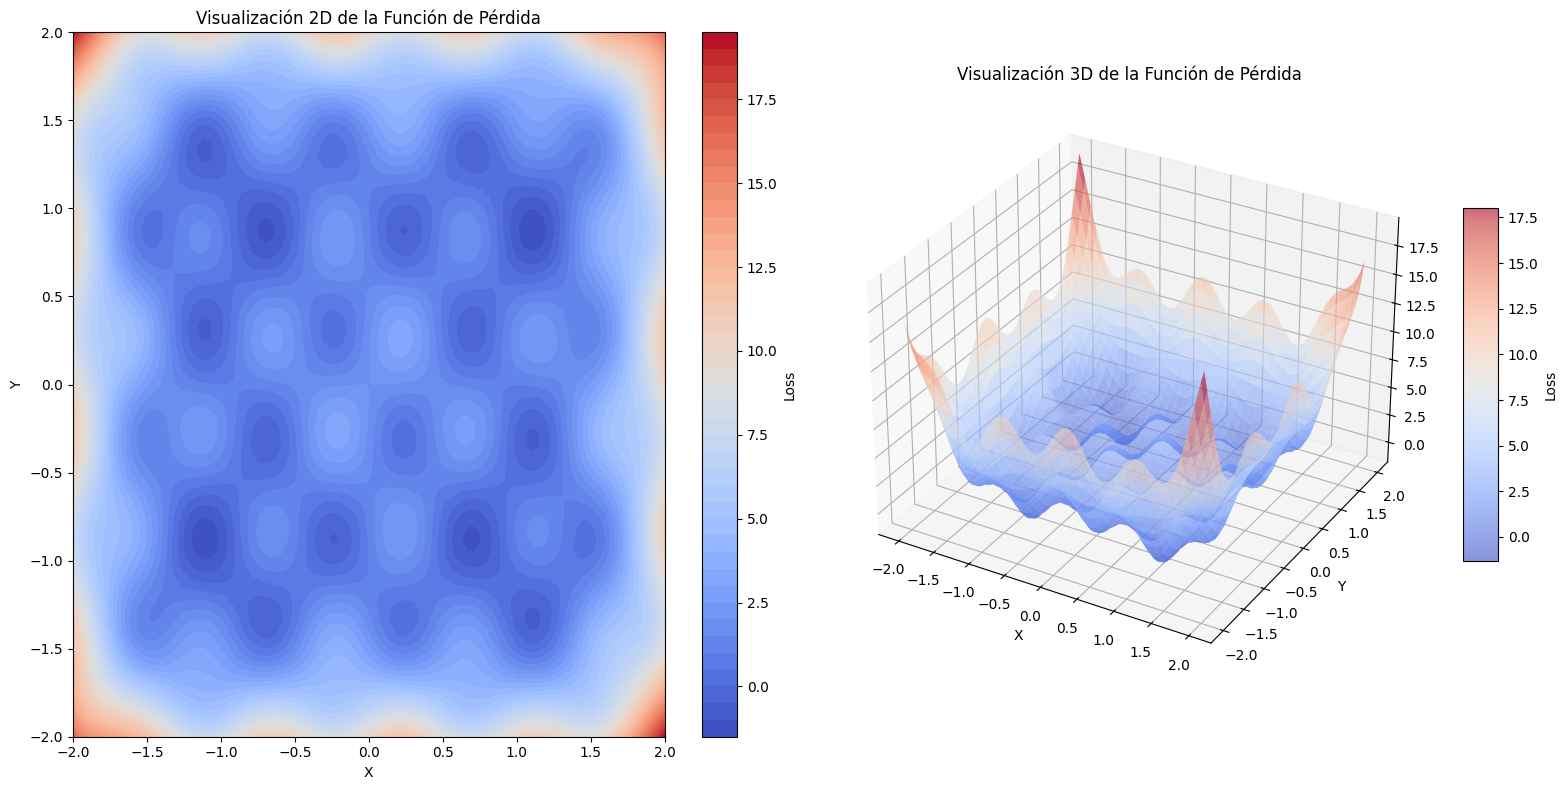

In [2]:
# Funcion de Perdidas 

def loss_function(x, y):
    
    loss = (x**2 - 1)**2 + (y**2 - 1)**2 + 1.5 * torch.sin(7 * x) * torch.sin(5.5 * y)
    
    return loss

# Funcion de Visualizacion de la Funcion de Perdidas

def plot_loss_fn(X, Y, Z):

    fig = plt.figure(figsize = (16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    contour = ax1.contourf(X, Y, Z, levels = 50, cmap = 'coolwarm')
    fig.colorbar(contour, ax = ax1, label = 'Loss')
    ax1.set_title('Visualización 2D de la Función de Pérdida')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
    surf = ax2.plot_surface(X, Y, Z, cmap = 'coolwarm', edgecolor = 'none', alpha = 0.6)
    fig.colorbar(surf, ax = ax2, shrink = 0.5, aspect = 10, label = 'Loss')
    ax2.set_title('Visualización 3D de la Función de Pérdida')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    
    plt.tight_layout()

    return plt.show()

# Visualizamos

x = torch.linspace(start = -2, end = 2, steps = 100)
y = torch.linspace(start = -2, end = 2, steps = 100)

X, Y = torch.meshgrid(x, y)

Z = loss_function(X, Y)

plot_loss_fn(X, Y, Z)

# **Adam**

**Hiperparametros:** 

* Ratio de Aprendizaje $\alpha$
* Funcion Objetivo Estocastica $f(\theta)$
* Parametros Inciales $\theta_{0}$
* Tasas de decaimiento exponencial para las estimaciones de momento $\beta_{1} \hspace{0.1cm} \beta_{2} \hspace{0.1cm} [0, 1)$

**Inicializacion:** 

* Vector del Primer Momento **(Media)**: $m_{0}$ 
* Vector del Segundo Momento **(Varianza)**: $v_{0}$ 
* Paso del Tiempo: $t$ 

$$m_{0} = 0 \hspace{1cm} v_{0} = 0 \hspace{1cm} t = 1$$

**Algoritmo:**

* Calculamos los Gradientes $g_{t} = \nabla_{\theta} f_{t}(\theta_{t-1})$
* Calculamos la Estimacion Sesgada del Primer Momento **(Media)** $m_{t} = \beta_{1} \cdot m_{t-1} + (1 - \beta_{1}) \cdot g_{t}$
* Calculamos la Estimacion Sesgada del Segundo Momento **(Varianza no Centrada)** $v_{t} = \beta_{2} \cdot v_{t-1} + (1 - \beta_{2}) \cdot g_{t}^2$
* Calculamos la Estimacion del Primer Momento **(Media)** con Correccion de Sesgo $\hat{m}_{t} = \frac{m_{t}}{(1 - \beta_{1}^t)}$
* Calculamos la Estimacion del Segundo Momento **(Varianza no Centrada)** con Correccion de Sesgo $\hat{v}_{t} = \frac{v_{t}}{(1 - \beta_{2}^t)}$
* Actualizamos los Parametros $\theta_{t} = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_{t}}{\sqrt{\hat{v}_{t}} + \epsilon}$

### **Calculo Manual** 

In [3]:
# Funcion de Actualizacion de Parametros

def update_params(params, mt, vt, t, lr, beta_1, beta_2, epsilon):     
    
    mt = beta_1 * mt + (1 - beta_1) * params.grad
    vt = beta_2 * vt + (1 - beta_2) * (params.grad)**2
    
    mt_right = mt / (1 - (beta_1)**t)
    vt_right = vt / (1 - (beta_2)**t)
    
    params.data -= lr * (mt_right / (torch.sqrt(vt_right) + epsilon))
    
    return params, mt, vt

# Funcion de Entrenamiento

def train_fuction(lr, n_iterations, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-8):
    
    params = torch.tensor([0.0, 3.0], requires_grad=True)
        
    mt = torch.zeros_like(params)
    vt = torch.zeros_like(params)
    
    grad_values = []
    loss_values = []
    params_values = []

    for t in range(1, n_iterations+1):        

        loss = loss_function(params[0], params[1])
        
        loss.backward()     
                       
        params, mt, vt = update_params(params, mt, vt, t, lr, beta_1 = beta_1, beta_2 = beta_2, epsilon = epsilon)
        
        loss_values.append(loss.item())
        params_values.append(params.clone().detach().numpy())  
        grad_values.append(params.grad.clone().detach().numpy())
        
        params.grad.zero_()
   
    grad_values = np.array(grad_values)
    loss_values = np.array(loss_values)
    params_values = np.array(params_values)

    return loss_values, params_values, grad_values
    
# Calculamos 

loss_manual, params_manual, grads_manual = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-8)        

### **Calculo Automatico**

In [4]:
# Funcion de Entrenamiento

def train_fuction(lr, n_iterations, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-8):

    params = torch.tensor([0.0, 3.0], requires_grad=True)

    optimizer = Adam(params = [params], lr = lr, betas = (beta_1, beta_2), eps = epsilon)

    grad_values = []
    loss_values = []
    params_values = []

    for _ in range(n_iterations):

        loss = loss_function(params[0], params[1])
        
        loss.backward()   
        
        optimizer.step()  
        
        loss_values.append(loss.item()) 
        params_values.append(params.clone().detach().numpy())  
        grad_values.append(params.grad.clone().detach().numpy())        
        
        optimizer.zero_grad()   

    grad_values = np.array(grad_values)
    loss_values = np.array(loss_values)
    params_values = np.array(params_values)

    return loss_values, params_values, grad_values

# Calculamos 

loss_automatic, params_automatic, grads_automatic = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-8)  

### **Comparativa**

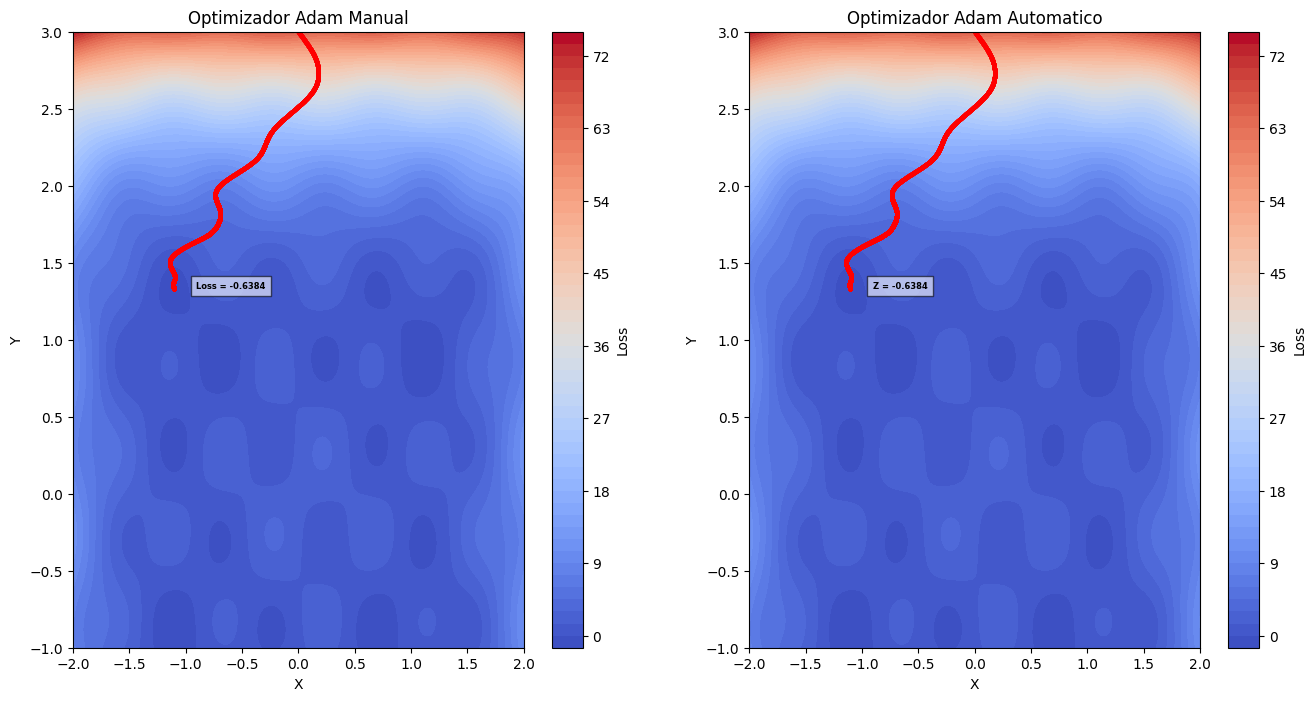

In [5]:
# Funcion de Visualizacion de la Comparativa

def plot_comparison(loss_manual, loss_automatic, params_manual, params_automatic, loss_function):

    X = np.linspace(-2, 2, 400)
    Y = np.linspace(-1, 3, 400)
    
    X, Y = np.meshgrid(X, Y)
    
    Z = loss_function(torch.tensor(X), torch.tensor(Y)).numpy()

    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    contour = ax1.contourf(X, Y, Z, levels = 50, cmap = 'coolwarm')
    
    fig.colorbar(contour, ax = ax1, label = 'Loss')
    ax1.plot(params_manual[:, 0], params_manual[:, 1], marker = 'o', color = 'red', markersize = 2, linestyle = '-', linewidth = 1)
    ax1.text(params_manual[-1, 0] + 0.2, params_manual[-1, 1], f'Loss = {loss_manual[-1]:0.4f}', color = 'black', fontsize = 6, weight = 'bold', bbox = dict(facecolor = 'white', alpha = 0.6))  
    ax1.set_title('Optimizador Adam Manual')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2 = fig.add_subplot(1, 2, 2)
    contour = ax2.contourf(X, Y, Z, levels = 50, cmap = 'coolwarm')
    
    fig.colorbar(contour, ax = ax2, label = 'Loss')
    ax2.plot(params_automatic[:, 0], params_automatic[:, 1], marker = 'o', color = 'red', markersize = 2, linestyle = '-', linewidth = 1)
    ax2.text(params_automatic[-1, 0] + 0.2, params_automatic[-1, 1], f'Z = {loss_automatic[-1]:0.4f}', color = 'black', fontsize = 6, weight = 'bold', bbox = dict(facecolor = 'white', alpha = 0.6))  
    ax2.set_title('Optimizador Adam Automatico')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    return plt.show()

# Visualizamos 

plot_comparison(loss_manual, loss_automatic, params_manual, params_automatic, loss_function)

# **Analisis de Hiperparametros**

### **General**

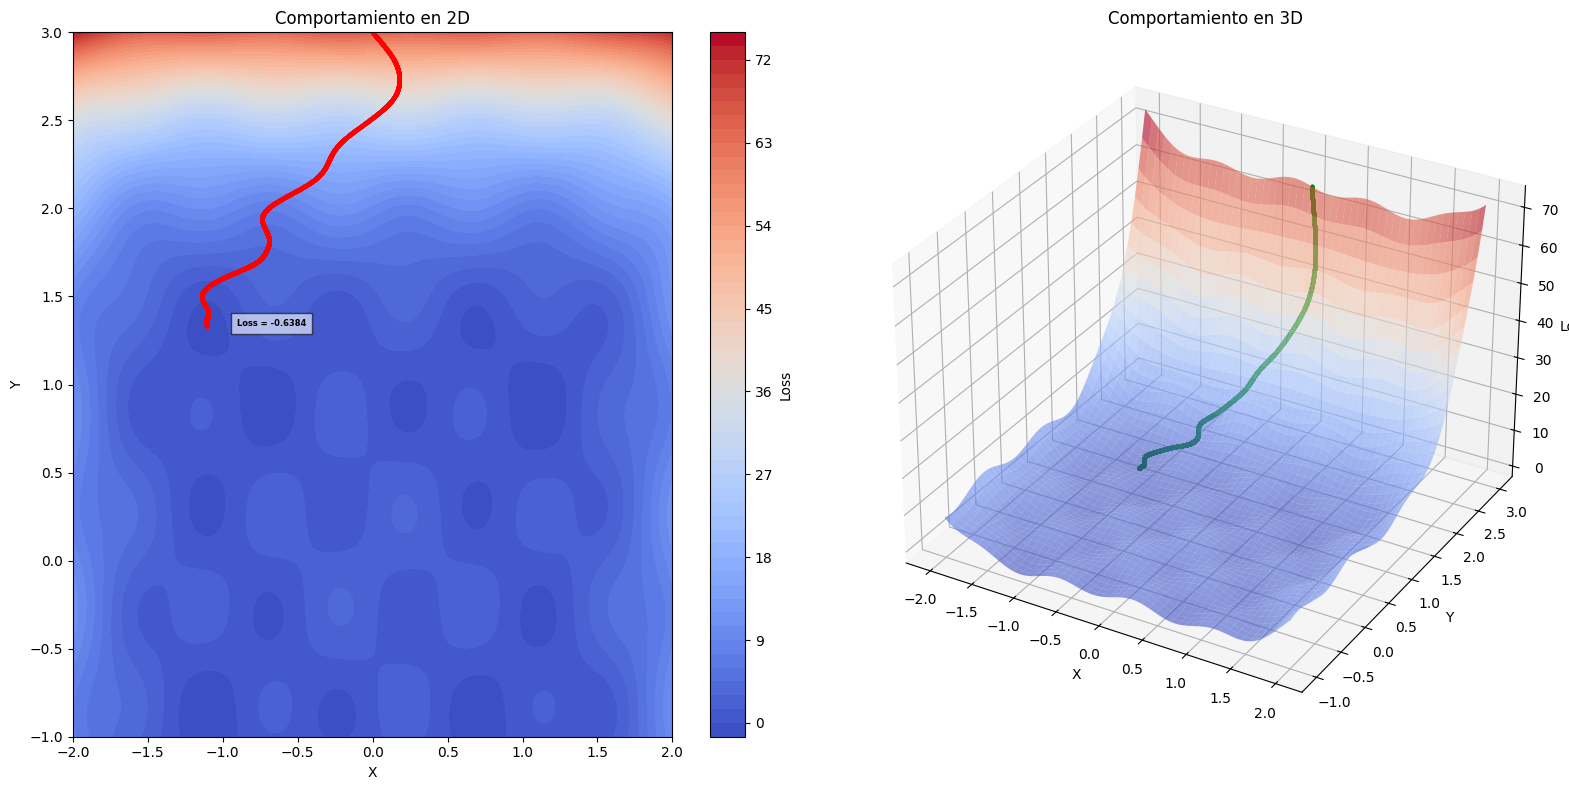

In [6]:
# Funcion de Visualizacion

def plot_behavior(loss, params, loss_fn):

    X = np.linspace(-2, 2, 400)
    Y = np.linspace(-1, 3, 400)
    X, Y = np.meshgrid(X, Y)
    Z = loss_fn(torch.tensor(X), torch.tensor(Y)).numpy()

    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    contour = ax1.contourf(X, Y, Z, levels = 50, cmap = 'coolwarm')
    
    fig.colorbar(contour, ax = ax1, label = 'Loss')
    ax1.plot(params[:, 0], params[:, 1], marker = 'o', color = 'red', markersize = 2, linestyle = '-', linewidth = 1)
    ax1.text(params[-1, 0] + 0.2, params[-1, 1], f'Loss = {loss[-1]:0.4f}', color = 'black', fontsize = 6, weight = 'bold', bbox = dict(facecolor = 'white', alpha = 0.6))  
    ax1.set_title('Comportamiento en 2D')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
    
    ax2.plot_surface(X, Y, Z, cmap = 'coolwarm', edgecolor = 'none', alpha = 0.6)
    ax2.plot(params[:, 0], params[:, 1], loss, marker = 'o', color = 'green', markersize = 2, linestyle = '-', linewidth = 1)
    ax2.set_title('Comportamiento en 3D')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Loss')
    
    plt.tight_layout()

    return plt.show()

# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.999, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

### **Primer Momento $m_{t}$**

Para Calcular la Estimacion Sesgada del Primer Momento **(Media)** utilizamos el concepto de media movil exponencial (EMA)

* Instante de Tiempo $t = 0$
$$m_{t=0} = 0$$

* Instante de Tiempo $t = 1$

$$m_{t=1} = \beta_{1} \cdot m_{t=0} + (1 - \beta_{1}) \cdot g_{t=1}$$
$$m_{t=1} = (1 - \beta_{1}) \cdot g_{t=1}$$

* Instante de Tiempo $t = 2$

$$m_{t=2} = \beta_{1} \cdot m_{t=1} + (1 - \beta_{1}) \cdot g_{t=2}$$
$$m_{t=2} = \beta_{1} \cdot (1 - \beta_{1}) \cdot g_{t=1} +  (1 - \beta_{1}) \cdot g_{t=2}$$

* Instante de Tiempo $t = 3$

$$m_{t=3} = \beta_{1} \cdot m_{t=2} + (1 - \beta_{1}) \cdot g_{t=3}$$
$$m_{t=3} = \beta_{1}^2 \cdot (1 - \beta_{1}) \cdot g_{t=1} +  \beta_{1} \cdot (1 - \beta_{1}) \cdot g_{t=2} +  (1 - \beta_{1}) \cdot g_{t=3}$$

* De forma general 

$$m_{t} = (1 - \beta_{1}) \sum_{i=0}^{t-1} \beta_{1}^i \cdot g_{t-1}$$

Dado que la estimación de  $m_{t}$ comienza en cero, en los primeros pasos subestima sistemáticamente el verdadero gradiente

$$\hat{m} = \frac{m_{t}}{1 - \beta_{1}^t}$$

Esta corrección se vuelve menos importante a medida que $t$ aumenta, ya que $(1 - \beta_{1}^t)$ tiende a 1 y el sesgo inicial desaparece.

**Conclusiones:** 

* A medida que $\beta_{1}$ aumenta, la memoria del optimizador se alarga, lo que significa que se le da más peso a los gradientes pasados al calcular la direccion del siguiente paso. Esto suaviza el movimiento a lo largo de la función de pérdida, evitando cambios bruscos en la actualización de los parámetros y haciendo el entrenamiento más estable. Sin embargo, si $\beta_{1}$ es demasiado alto, la adaptación a nuevas tendencias en los gradientes será más lenta.

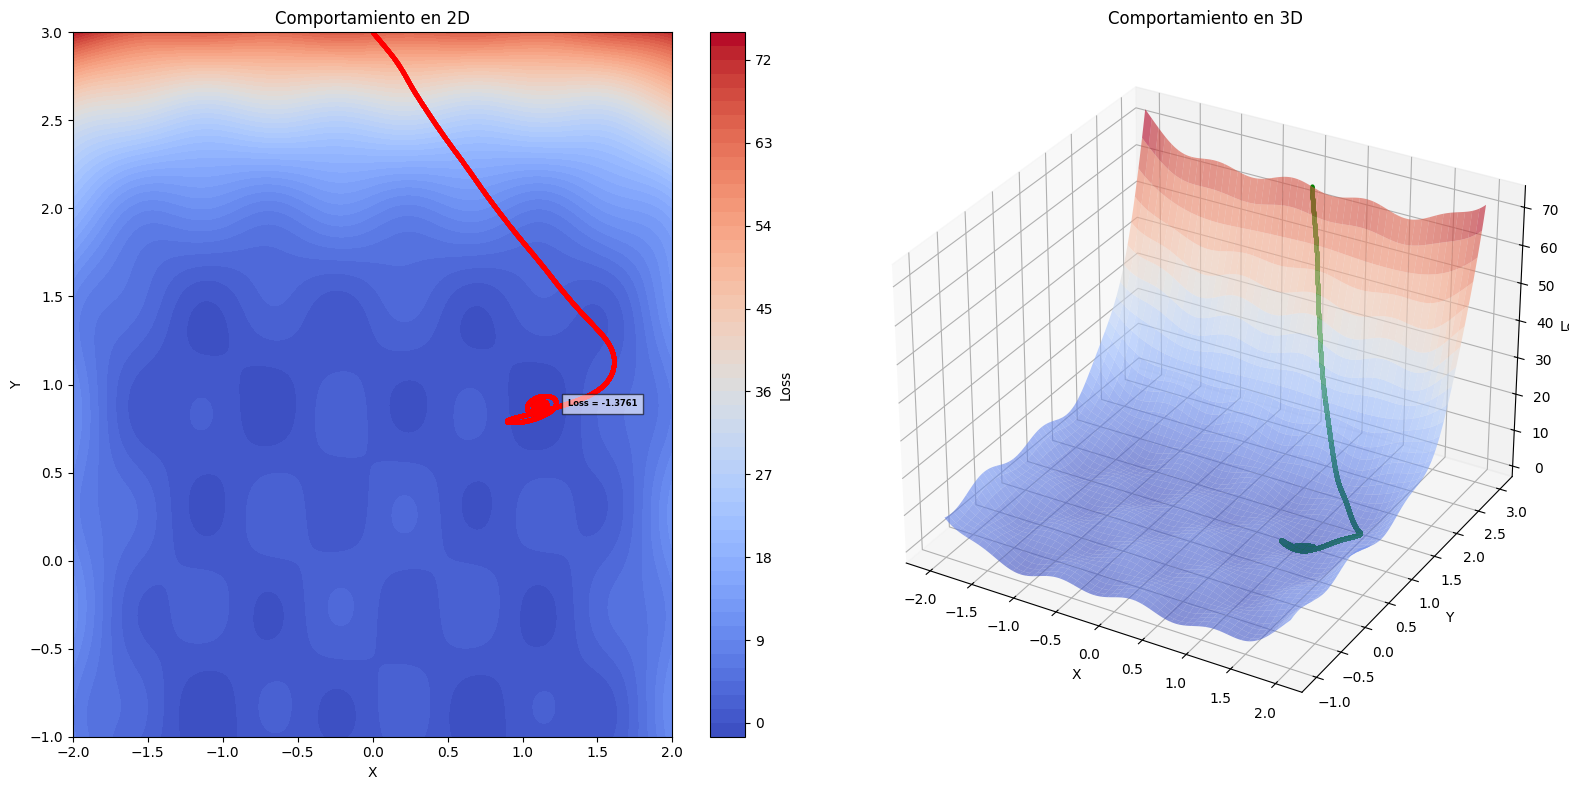

In [7]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.999, beta_2 = 0.999, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

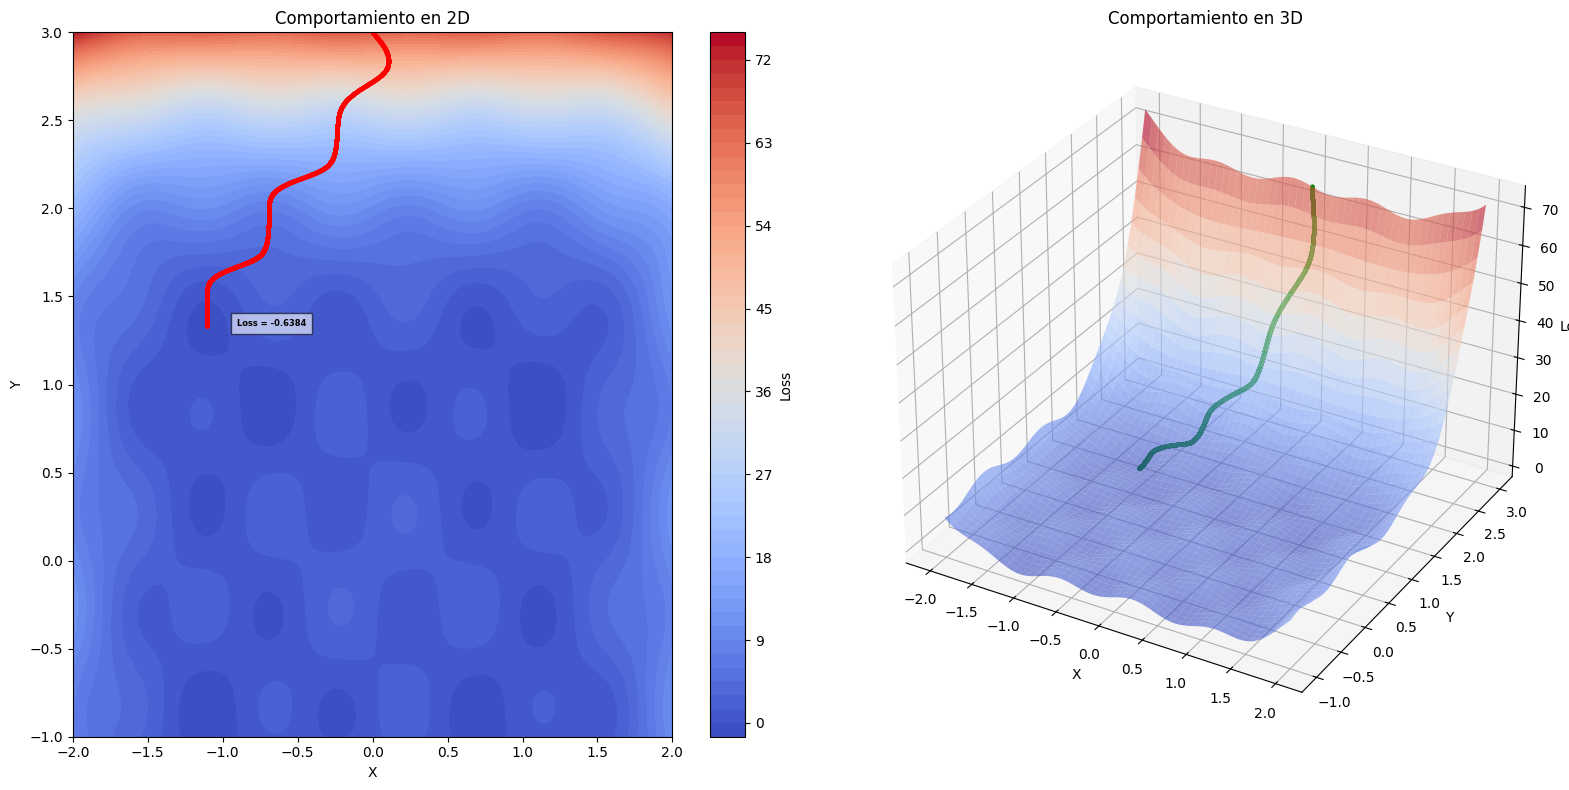

In [8]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

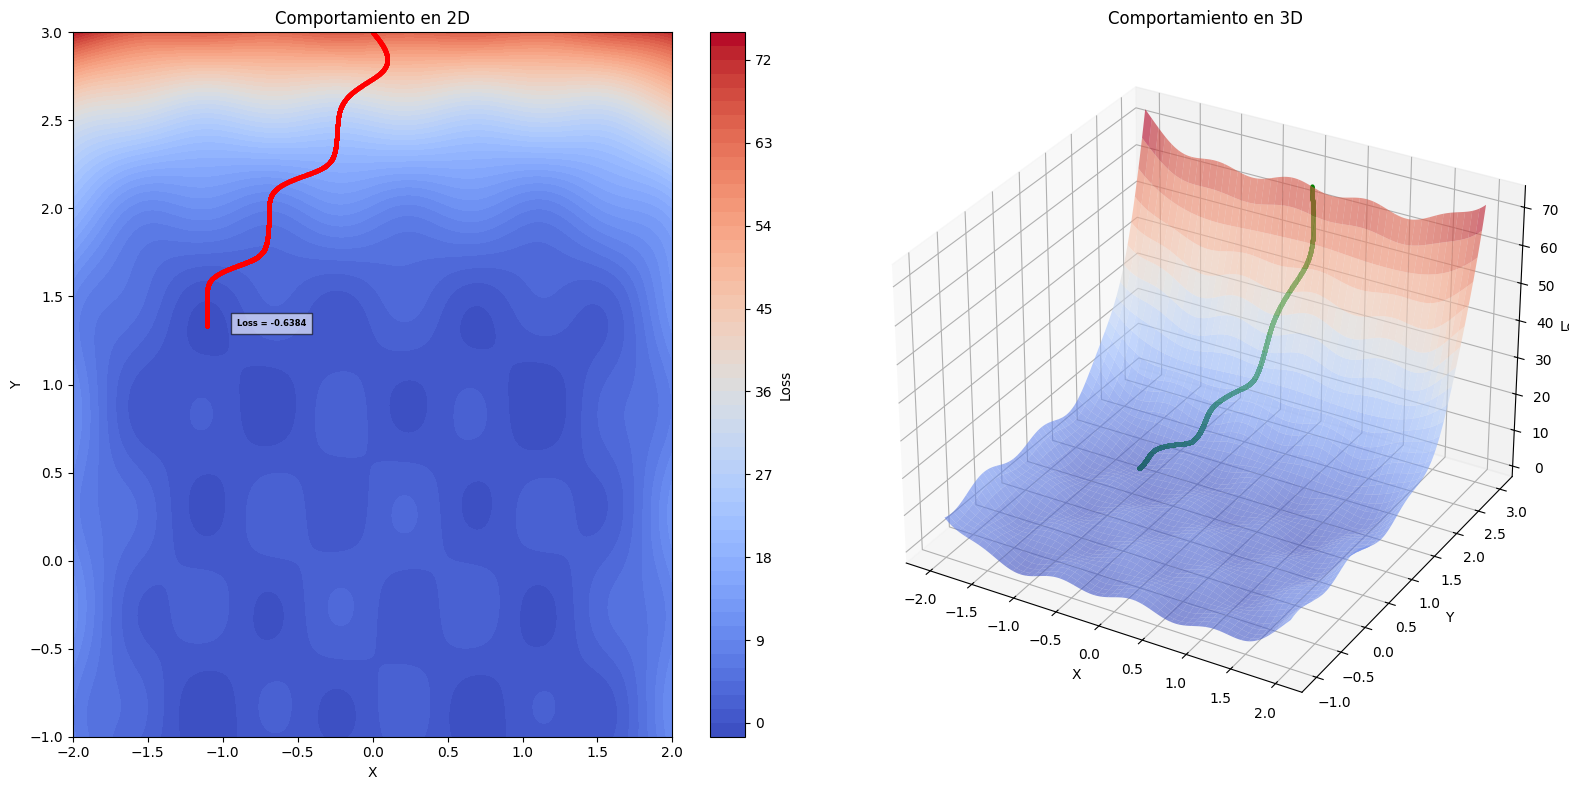

In [9]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.6, beta_2 = 0.999, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

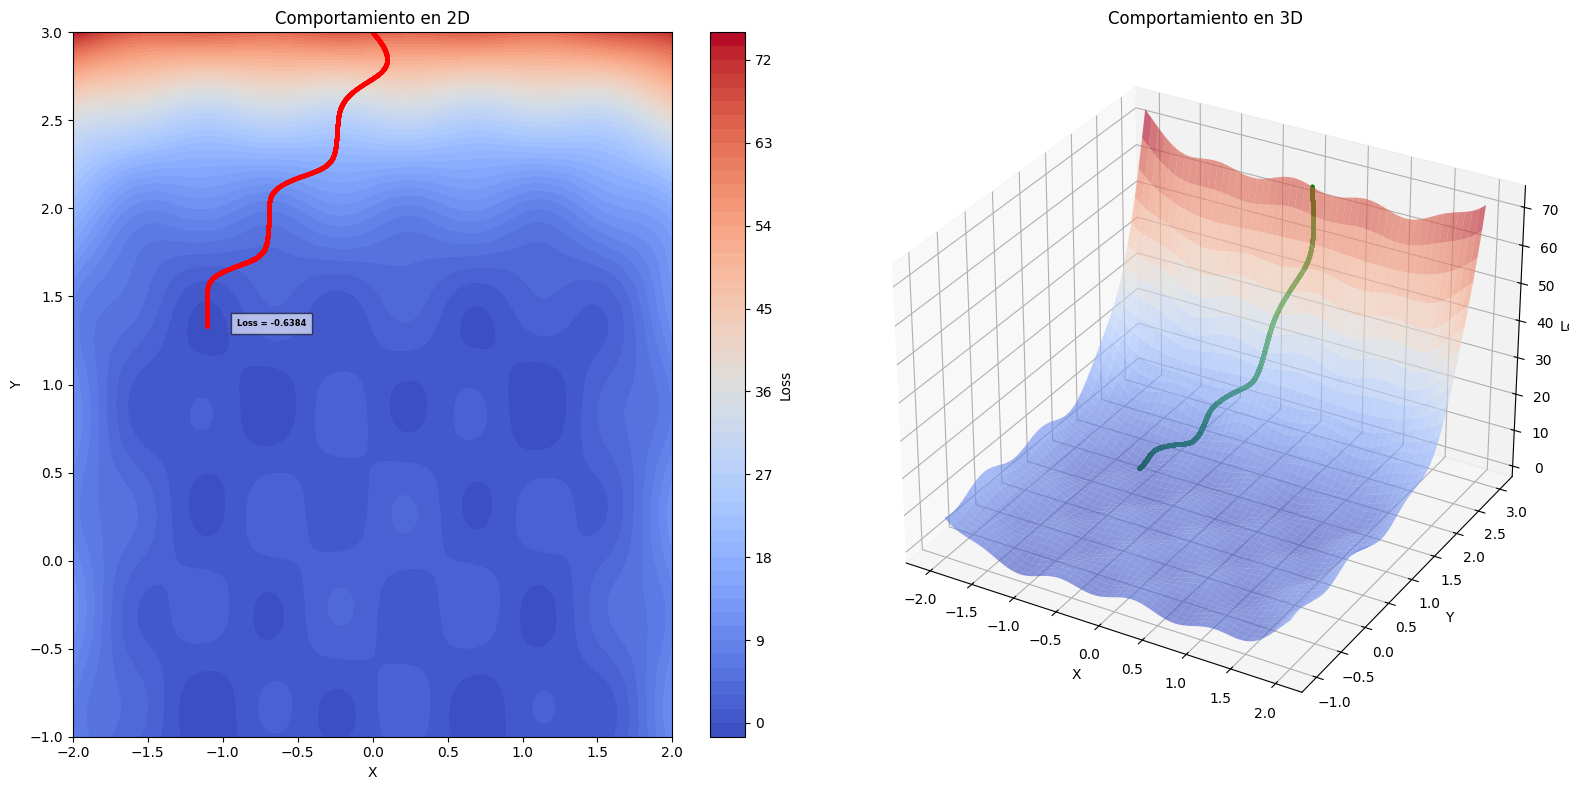

In [10]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.3, beta_2 = 0.999, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

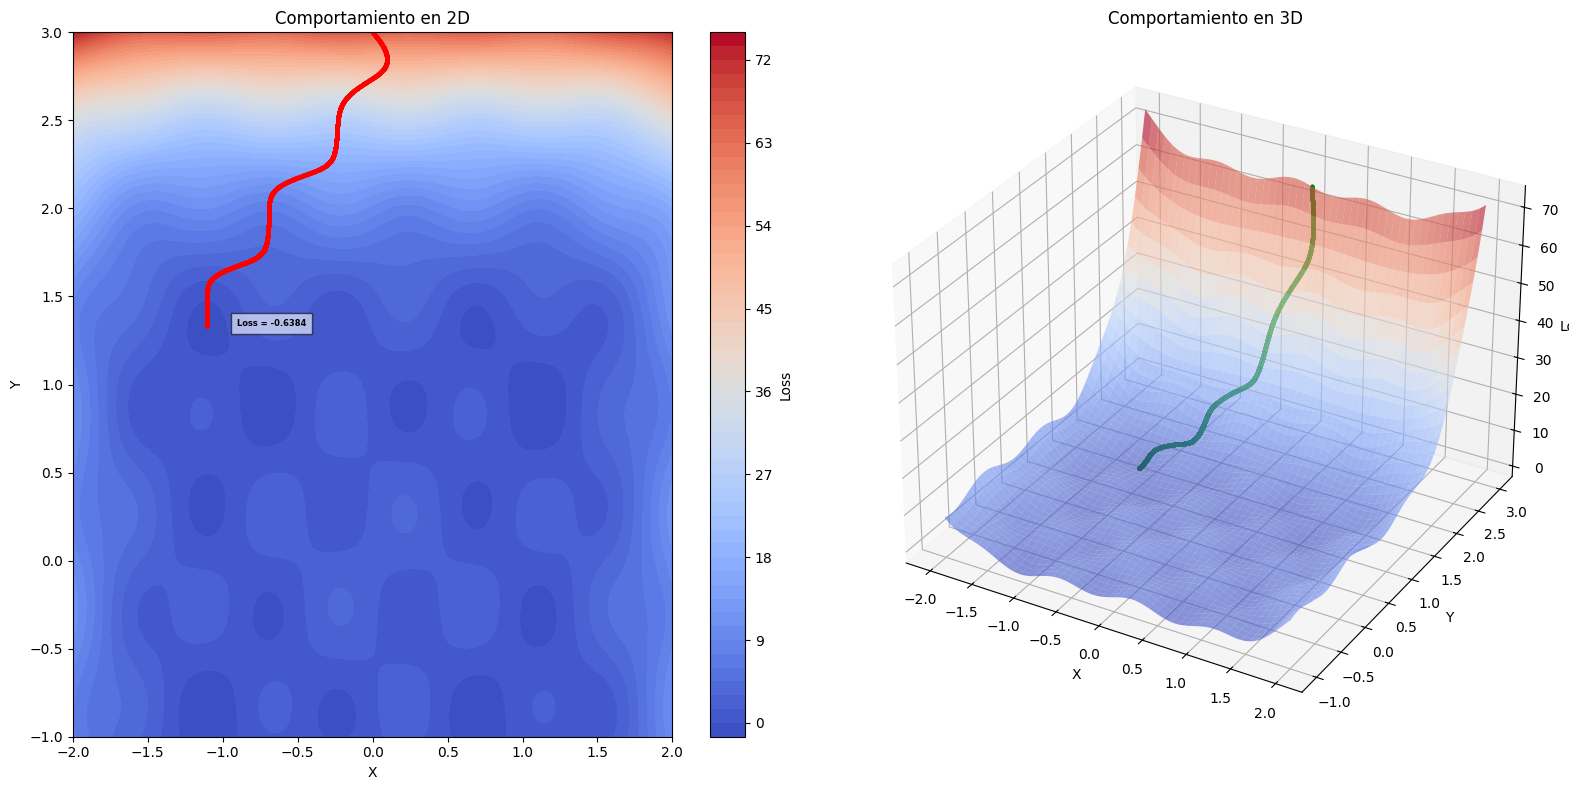

In [11]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.01, beta_2 = 0.999, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

### **Segundo Momento $v_{t}$**

Para Calcular la Estimacion Sesgada del Segundo Momento **(Varianza)** utilizamos el concepto de media movil exponencial (EMA)

* Instante de Tiempo $t = 0$
$$v_{t=0} = 0$$

* Instante de Tiempo $t = 1$

$$v_{t=1} = \beta_{2} \cdot v_{t=0} + (1 - \beta_{2}) \cdot g_{t=1}^2$$
$$v_{t=1} = (1 - \beta_{2}) \cdot g_{t=1}^2$$

* Instante de Tiempo $t = 2$

$$v_{t=2} = \beta_{2} \cdot v_{t=1} + (1 - \beta_{2}) \cdot g_{t=2}^2$$
$$v_{t=2} = \beta_{2} \cdot (1 - \beta_{2}) \cdot g_{t=1}^2 +  (1 - \beta_{2}) \cdot g_{t=2}^2$$

* Instante de Tiempo $t = 3$

$$v_{t=3} = \beta_{2} \cdot v_{t=2} + (1 - \beta_{2}) \cdot g_{t=3}^2$$
$$v_{t=3} = \beta_{2}^2 \cdot (1 - \beta_{2}) \cdot g_{t=1}^2 +  \beta_{2} \cdot (1 - \beta_{2}) \cdot g_{t=2}^2 +  (1 - \beta_{2}) \cdot g_{t=3}^2$$

* De forma general 

$$v_{t} = (1 - \beta_{2}) \sum_{i=0}^{t-1} \beta_{2}^i \cdot g_{t-1}^2$$

Dado que la estimación de  $v_{t}$ comienza en cero, en los primeros pasos subestima sistemáticamente la verdadera varianza del gradiente

$$\hat{v} = \frac{v_{t}}{1 - \beta_{2}^t}$$

Esta corrección se vuelve menos importante a medida que $t$ aumenta, ya que $(1 - \beta_{2}^t)$ tiende a 1 y el sesgo inicial desaparece.

**Conclusiones:** 

* A medida que $\beta_{2}$ aumenta, la memoria del optimizador se alarga, lo que significa que se le da más peso a los gradientes pasados al estimar la varianza. Esto establiza la escala de los pasos de actualizacion, evitando oscilaciones abruptas y haciendo el entrenamiento mas robusto, Sin embargo si $\beta_{2}$ es demasiado alto, la estimación de la varianza reaccionará más lentamente a cambios en la dispersión de los gradientes, lo que puede dificultar la adaptación a regiones con curvaturas distintas en la función de pérdida.

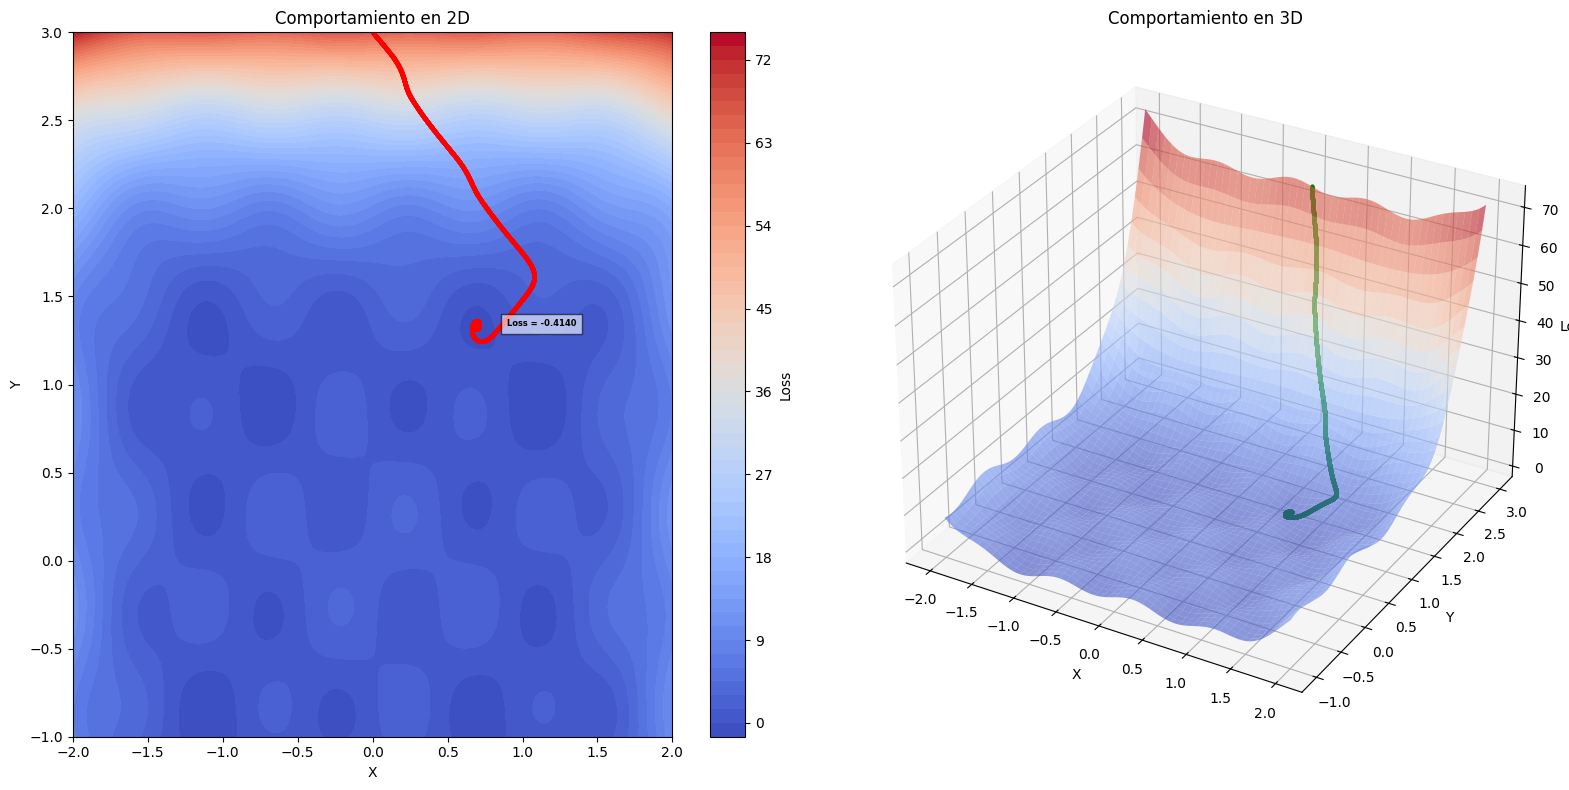

In [12]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.99, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

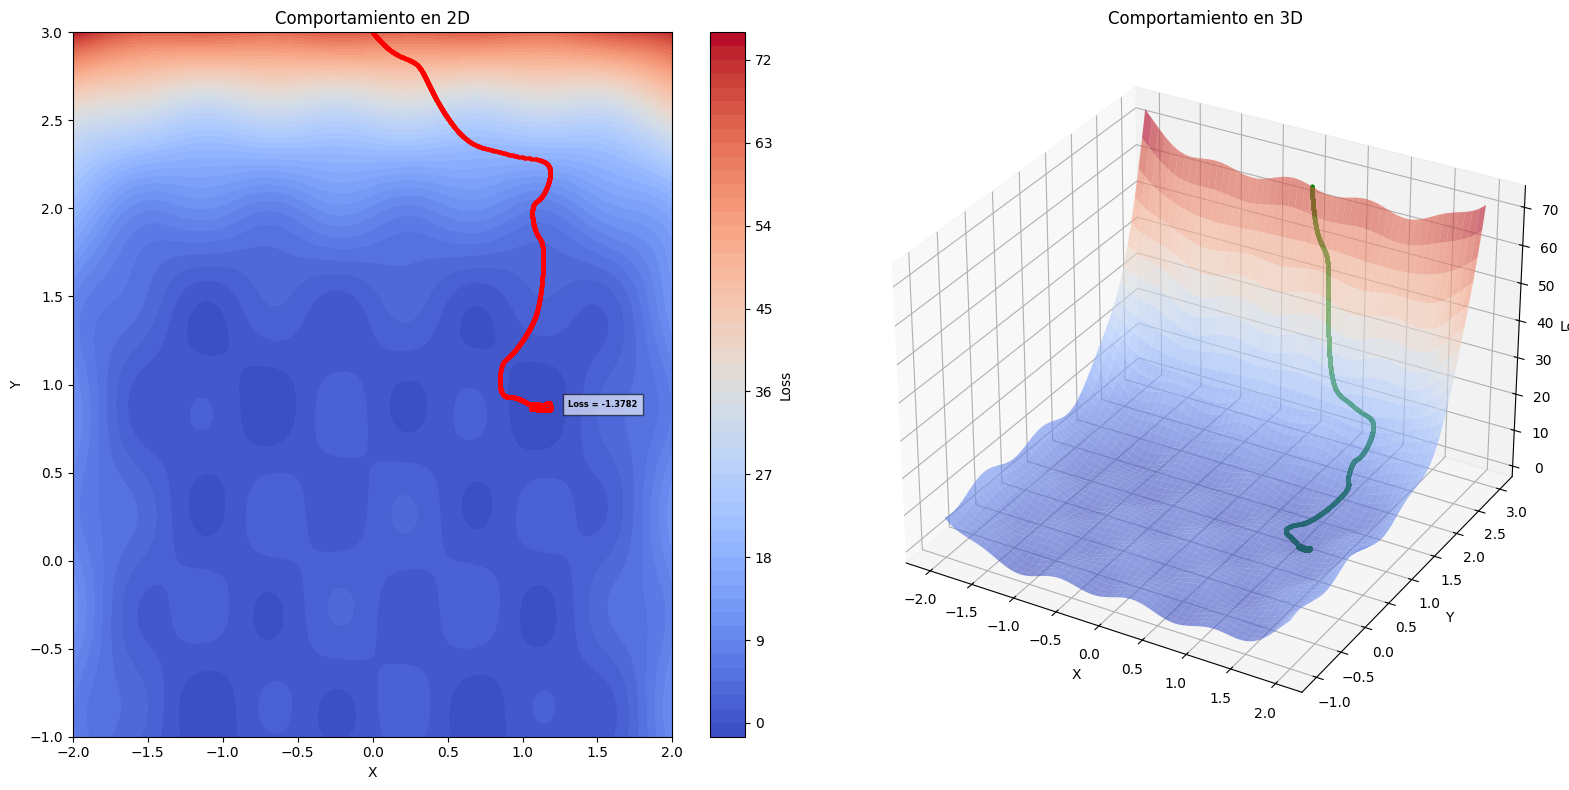

In [13]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.9, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

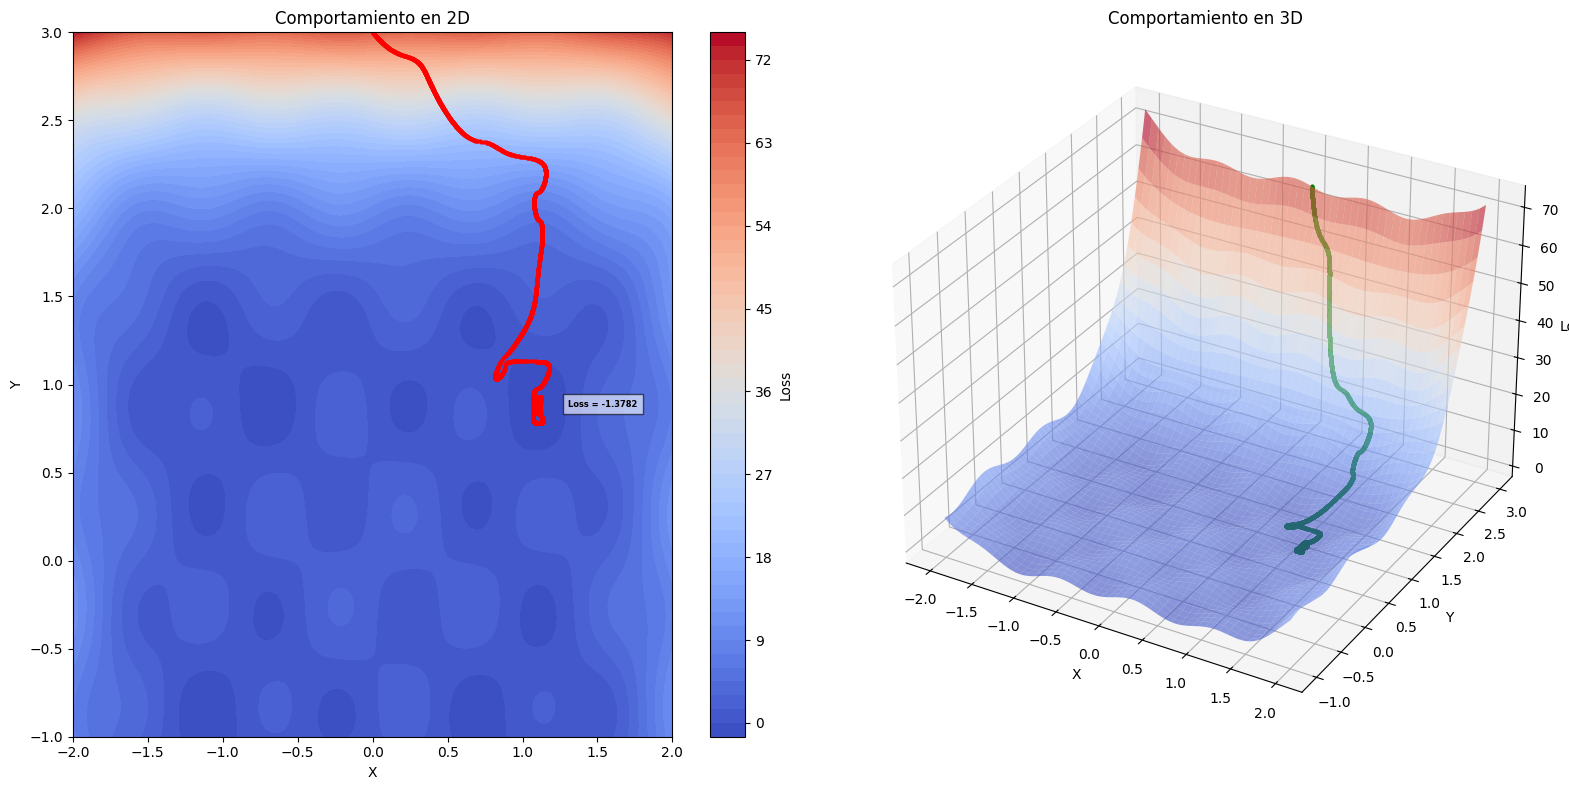

In [14]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.6, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

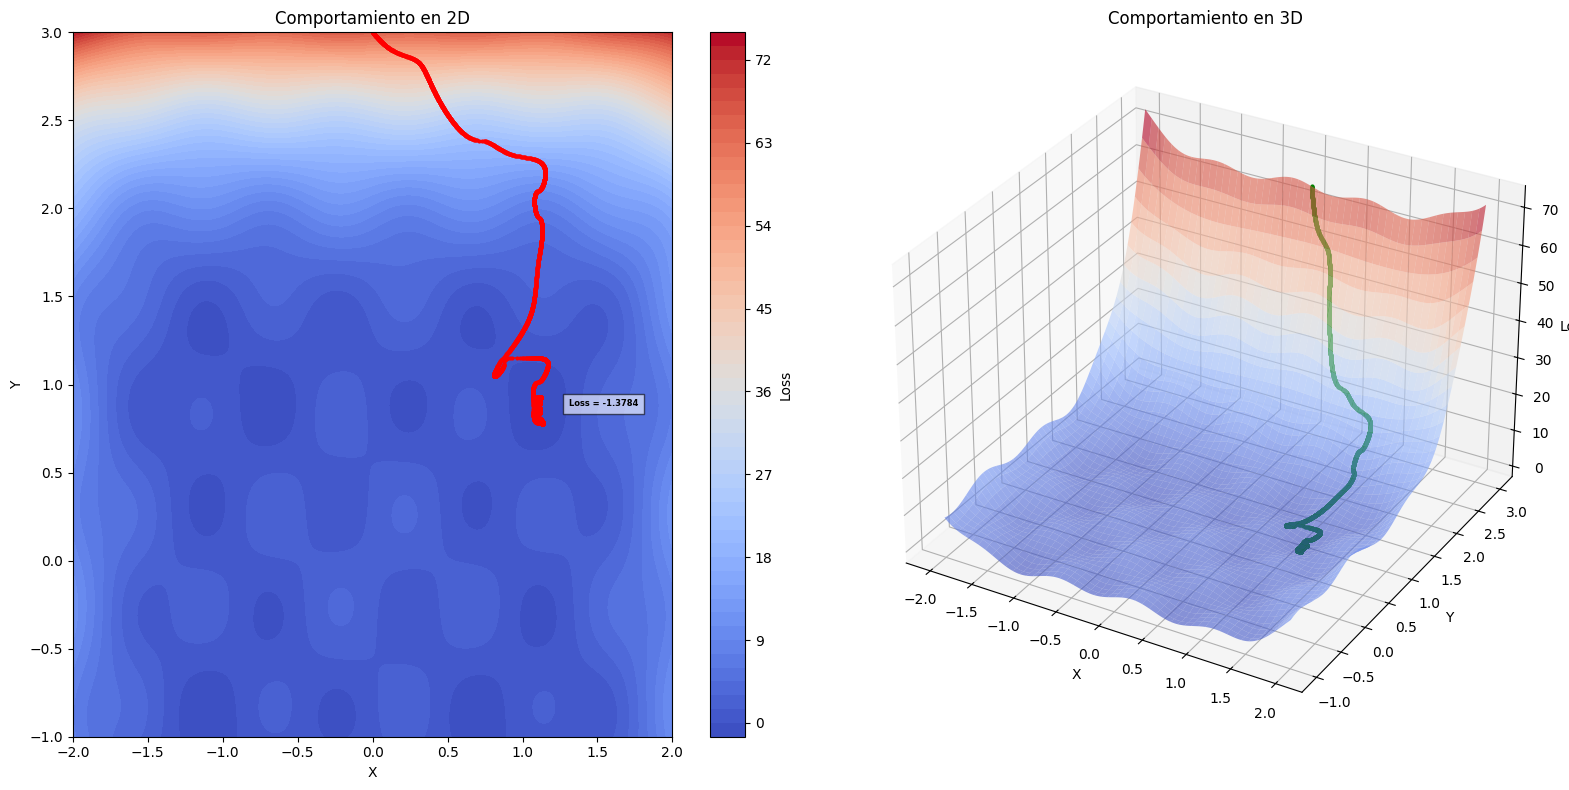

In [15]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.3, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)

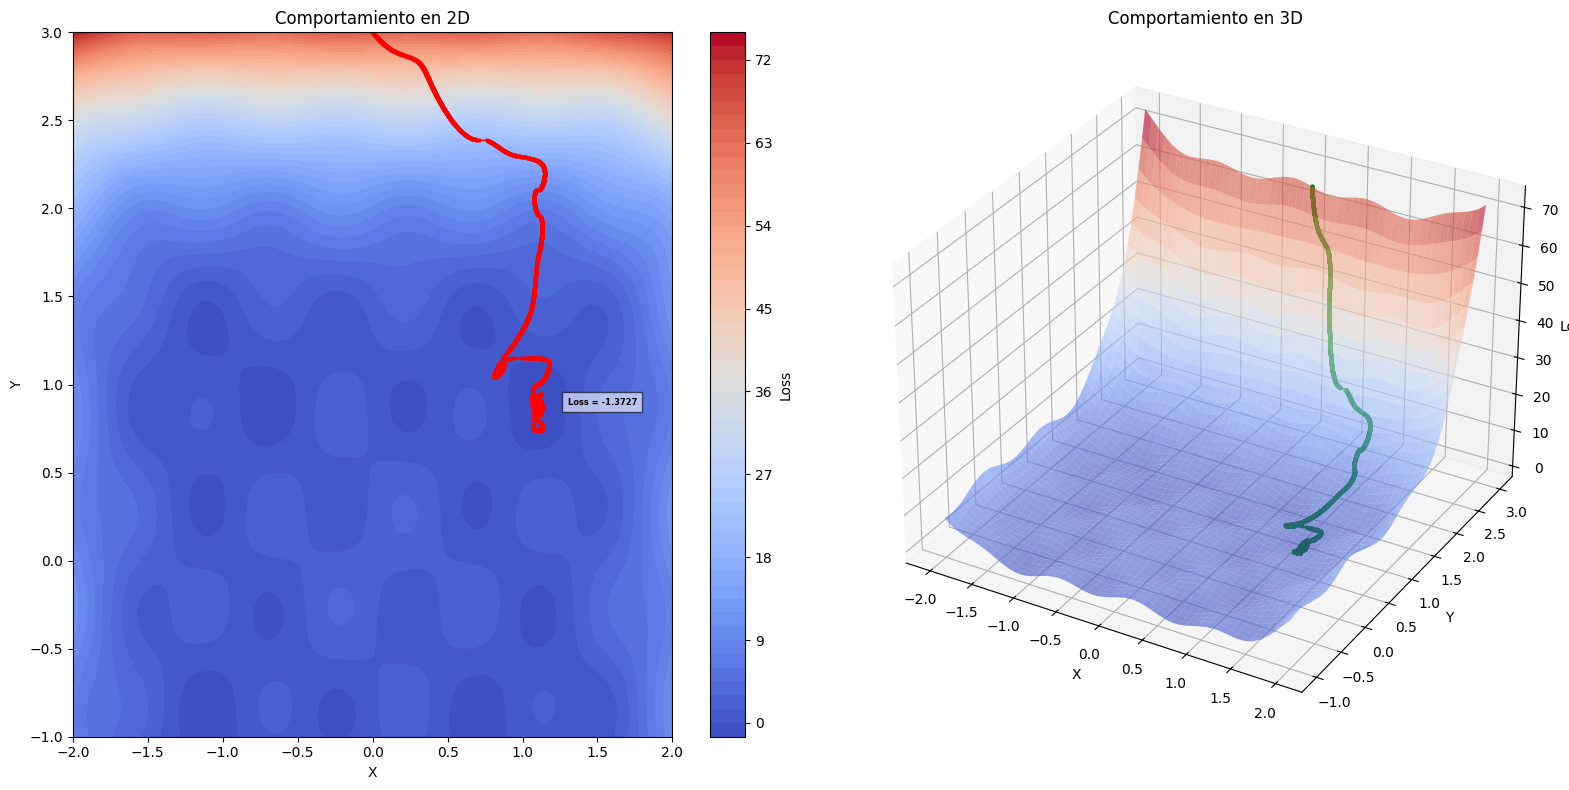

In [16]:
# Entrenamos 

loss, params, grads = train_fuction(lr = 0.001, n_iterations = 10000, beta_1 = 0.99, beta_2 = 0.01, epsilon = 1e-8)  

# Visualizamos 

plot_behavior(loss, params, loss_function)